# Analysis of Vivino user preferences

## Factors affecting the price

In this mission our goal is to understand which factors (of those available to our analysis) contribute to the price of the wine. 
The following questions can be analyzed in more detail: 
* how different features influence the price of a bottle of wine
* analyze the connection between ratings and price (whether variance in scores increases for more expensive wines) 
* see whether temperature in particular regions can affect the price 
* see whether it's possible to get a score adjusted to price (i.e. eliminate bias in user expectatoins in view of the price)
* estimate the predictive power for the rating with price and without price

In [1]:
from sqlalchemy import create_engine
import pymysql
import pandas as pd
from settings import * 

db_connection_str = f'mysql+pymysql://admin:{db_pass}@{db_url}:3306/vivino'
db_connection = create_engine(db_connection_str)

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

We will work with a dataframe containing all features that might be important for our analysis. In order to do that we need to join several tables from our SQL database.

Below is the query that extracts all potentially relevant information from the database: 
about the vintage itself (eg. year, price, ratings), type (red/white/etc), wine qualities (flavour, intensity, acidity, etc), country, region, winery, style, bottle type (to select only those with classic bottle size), number of grape varieties used, appearance in toplists and average rank.

In [172]:
query = (
"""
SELECT v.id, v.year, v.ratings_count, v.ratings_average, v.price, 
w.acidity, w.fizziness, w.intensity, w.sweetness, w.tannin, w.vintage_type, w.is_natural, w.seo_name AS wine_name, w.id AS wine_id,
r.name AS region, 
c.name AS country,
s.name AS style_name, s.body, s.acidity AS style_acidity,
t.name AS type_name,
w2.name AS winery_name,
p.bottle_type,
GROUP_CONCAT(distinct g.name ORDER BY g.name SEPARATOR ', ') AS grapes,
COUNT(distinct vt.toplist_id) AS toplist_count, AVG(vt.rank) AS average_rank,
COUNT(distinct sg.grape_id) AS grape_count
FROM vintage AS v
LEFT JOIN wine AS w ON w.id = v.wine_id
LEFT JOIN region AS r ON w.region_id = r.id
LEFT JOIN country AS c on r.country_code = c.code
LEFT JOIN style AS s ON w.style_id = s.id
LEFT JOIN type AS t ON t.id = w.type_id
LEFT JOIN style_grape AS sg ON sg.style_id = s.id
LEFT JOIN grape AS g ON sg.grape_id = g.id
LEFT JOIN winery AS w2 ON w2.id = w.winery_id
LEFT JOIN price AS p ON v.price_id = p.id
LEFT JOIN vintage_toplist AS vt ON vt.vintage_id = v.id
GROUP BY v.id
"""
)

df = pd.read_sql(query, con=db_connection)
df.head()

,id,year,ratings_count,ratings_average,price,acidity,fizziness,intensity,sweetness,tannin,...,style_name,body,style_acidity,type_name,winery_name,bottle_type,grapes,toplist_count,average_rank,grape_count
0,1832,2005,169,4.5,299.500,3.39891,NaN,3.98319,1.71259,3.52832,...,Australian Cabernet Sauvignon,4.0,3.0,Red,Penfolds,Bottle (0.75l),Cabernet Sauvignon,0,NaN,1
1,2036,2005,537,4.4,46.390,3.10746,NaN,3.43923,1.82238,2.92387,...,Tuscan Red,3.0,2.0,Red,Mazzei,Bottle (0.75l),"Cabernet Sauvignon, Canaiolo Nero, Merlot, San...",0,NaN,4
2,2201,2005,804,4.6,432.500,3.07319,NaN,3.40041,1.89079,2.95559,...,Tuscan Red,3.0,2.0,Red,Antinori,Bottle (0.75l),"Cabernet Sauvignon, Canaiolo Nero, Merlot, San...",0,NaN,4
3,2202,2005,1745,4.5,102.840,3.07621,NaN,3.38235,1.71550,2.96347,...,Tuscan Red,3.0,2.0,Red,Antinori,Bottle (0.75l),"Cabernet Sauvignon, Canaiolo Nero, Merlot, San...",0,NaN,4
4,2225,2003,213,4.3,116.667,3.80301,NaN,3.19779,1.59608,3.42035,...,Italian Brunello,5.0,3.0,Red,Antinori,Bottle (0.75l),Sangiovese,0,NaN,1


## Overview of variables

First, we review each column and its statistics (that differs between numerical and categorical variables).

In [136]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55819 entries, 0 to 55818
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               55819 non-null  int64  
 1   year             55819 non-null  int64  
 2   ratings_count    55819 non-null  int64  
 3   ratings_average  55819 non-null  float64
 4   price            55819 non-null  float64
 5   acidity          48202 non-null  float64
 6   fizziness        1508 non-null   float64
 7   intensity        48202 non-null  float64
 8   sweetness        46694 non-null  float64
 9   tannin           33554 non-null  float64
 10  vintage_type     55819 non-null  int64  
 11  is_natural       55819 non-null  int64  
 12  wine_name        55819 non-null  object 
 13  wine_id          55819 non-null  int64  
 14  region           55773 non-null  object 
 15  country          55773 non-null  object 
 16  style_name       49766 non-null  object 
 17  body        

In [139]:
df.iloc[:,1:15].describe(include='all')

,year,ratings_count,ratings_average,price,acidity,fizziness,intensity,sweetness,tannin,vintage_type,is_natural,wine_name,wine_id,region
count,55819.000000,55819.000000,55819.000000,55819.000000,48202.000000,1508.000000,48202.000000,46694.000000,33554.000000,55819.000000,55819.000000,55819,5.581900e+04,55773
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21100,NaN,1656
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pomerol,NaN,Saint-Émilion Grand Cru
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,750,NaN,1259
mean,1988.488794,302.603845,3.993465,92.111515,3.591589,4.121940,3.658274,1.759363,3.271468,0.013687,0.044537,NaN,1.614050e+06,NaN
std,219.818566,1063.017821,0.320202,615.417848,0.634221,0.617640,0.731353,0.494513,0.654076,0.119083,0.206286,NaN,1.582791e+06,NaN
min,0.000000,25.000000,2.300000,1.470000,1.105340,1.000000,1.000000,1.000000,1.054910,0.000000,0.000000,NaN,2.960000e+02,NaN
25%,2012.000000,49.000000,3.800000,14.990000,3.135020,3.905885,3.097400,1.502660,2.854580,0.000000,0.000000,NaN,7.687330e+05,NaN
50%,2015.000000,102.000000,4.000000,26.340000,3.572490,4.334035,3.810690,1.657575,3.334230,0.000000,0.000000,NaN,1.219018e+06,NaN
75%,2017.000000,252.000000,4.200000,55.000000,4.076560,4.428698,4.185860,1.877500,3.697835,0.000000,0.000000,NaN,1.901594e+06,NaN


In [140]:
df.iloc[:,15:].describe(include='all')

,country,style_name,body,style_acidity,type_name,winery_name,bottle_type,grapes,toplist_count,average_rank,grape_count
count,55773,49766,49766.000000,49766.000000,55819,55803,55819,49766,55819.000000,1457.000000,55819.000000
unique,47,283,NaN,NaN,7,10026,3,206,NaN,NaN,NaN
top,France,Burgundy Côte de Nuits Red,NaN,NaN,Red,M. Chapoutier,Bottle (0.75l),"Cabernet Franc, Cabernet Sauvignon, Carménère,...",NaN,NaN,NaN
freq,23031,2166,NaN,NaN,36593,248,53808,7236,NaN,NaN,NaN
mean,NaN,NaN,3.745971,2.816401,NaN,NaN,NaN,NaN,0.034039,6.137497,2.402121
std,NaN,NaN,0.857454,0.434923,NaN,NaN,NaN,NaN,0.232269,3.984397,1.954671
min,NaN,NaN,1.000000,1.000000,NaN,NaN,NaN,NaN,0.000000,1.000000,0.000000
25%,NaN,NaN,3.000000,3.000000,NaN,NaN,NaN,NaN,0.000000,3.000000,1.000000
50%,NaN,NaN,4.000000,3.000000,NaN,NaN,NaN,NaN,0.000000,6.000000,1.000000
75%,NaN,NaN,4.000000,3.000000,NaN,NaN,NaN,NaN,0.000000,9.000000,4.000000


In [141]:
df[df['year'] != 0].year.value_counts().sort_index()

1818       1
1900       1
1910       1
1912       1
1920       1
        ... 
2016    7575
2017    7773
2018    7576
2019    3063
2020      34
Name: year, Length: 91, dtype: int64

The following columns have null values: 
* acidity, intensity, sweetness, tannin (if necessary, can be resolved by imputation from similar style) 
* fizziness (can be either resolved by imputation from similar style, or dropped completely) 
* region, country (can be dropped) 
* winery name (can be dropped) 
* average rank (can impute certain value exceeding the highest value among non-nulls, for example, 30)
* style, body (can be dropped) 
* style_acidity (can be dropped since it repeats the acidity columns)

Some information about the features: 
* `year`: from 1818 to 2020, median 2015, also includes non-vintage years (marked as 0)
* `ratings_count`: around 300 in average per vintage
* `ratings_average`: from 2.3 to 5 with mean around 3.99
* `price`: from 1.5 GBP to 42.1 th GBP, median price around 26 GBP
* `acidity` (as opposed to softness), `fizziness`, `intensity`, `sweetness` (as opposed to dryness), `tannin`: range from 1 to 5
* `vintage_type`: 0, 1 or 2, exact nature yet unclear
* `is_natural`: 0 or 1
* `wine_name`: around 21.1 th unique records
* `region`: 1656 unique records
* `country`: 47 unique records
* `style_name`: 283 unique records
* `body` (as opposed to lightness) and `style_acidity`: range from 1 to 5
* `type_name`: Red, White, Sparkling, Rose, Dessert, Fortified, Other
* `winery_name`: more than 10 ths unique wineries
* `bottle_type`: normal bottle (0.75l) for most of the wines, half bottle (0.375l) or magnum bottle (1.5l)
* `toplist_count`: how many times certain vintage appears in any toplists (up to 30)
* `average_rank`: for those vintages that appear in toplists, this represents the average rank, ranging from 1 to 20
* `grape_count`: the number of distinct types of grapes used to prepare wine, ranging from 1 to 30

In [142]:
df.columns

Index(['id', 'year', 'ratings_count', 'ratings_average', 'price', 'acidity',
       'fizziness', 'intensity', 'sweetness', 'tannin', 'vintage_type',
       'is_natural', 'wine_name', 'wine_id', 'region', 'country', 'style_name',
       'body', 'style_acidity', 'type_name', 'winery_name', 'bottle_type',
       'grapes', 'toplist_count', 'average_rank', 'grape_count'],
      dtype='object')

Now we'll visualize some of the frequency distributions of the variables in our table

In [143]:
sns.set_theme(font='georgia')
sns.set_context(rc={'font.size': 8, 
                    'axes.titlesize': 20, 
                    'axes.labelsize':16, 
                    'legend.title_fontsize': 14})   

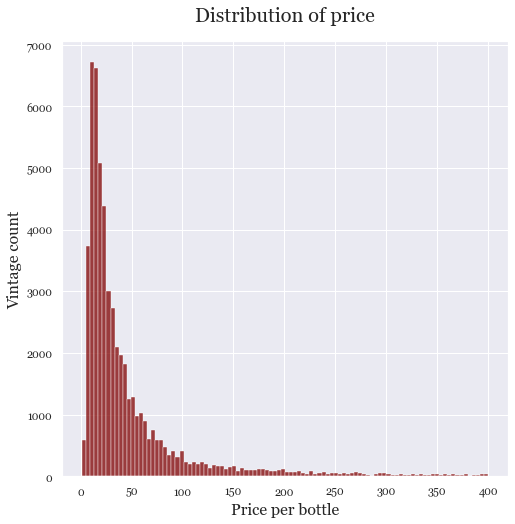

In [144]:
plt.figure(figsize=(8, 8))
sns.histplot(data=df[df.price < 400], x='price', bins=100, color='maroon')
plt.xlabel('Price per bottle')
plt.ylabel('Vintage count')
plt.title('Distribution of price', pad=20)
plt.show()

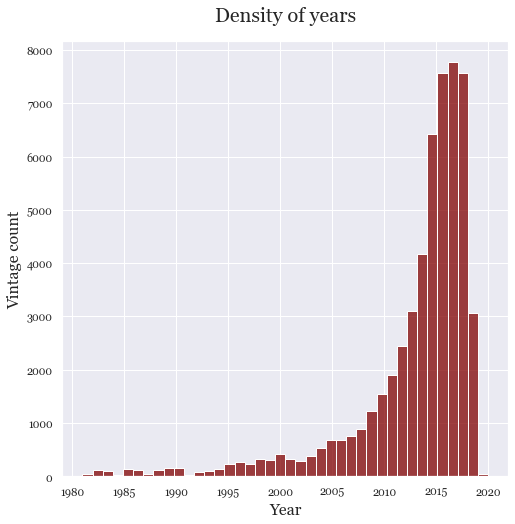

In [145]:
plt.figure(figsize=(8, 8))
sns.histplot(data=df[df.year > 1980], x='year', bins=40, color='maroon')
plt.xlabel('Year')
plt.ylabel('Vintage count')
plt.title('Density of years', pad=20)
plt.show()
# sns.plotting_context()

In [147]:
def modify_legend(ax, new_title, new_loc='upper left', facecolor='white', **kws):
    old_legend = ax.legend_
    handles = old_legend.legendHandles
    labels = [t.get_text() for t in old_legend.get_texts()]
#     title = old_legend.get_title().get_text()
    ax.legend(handles, labels, loc=new_loc, facecolor=facecolor, title=new_title, **kws)

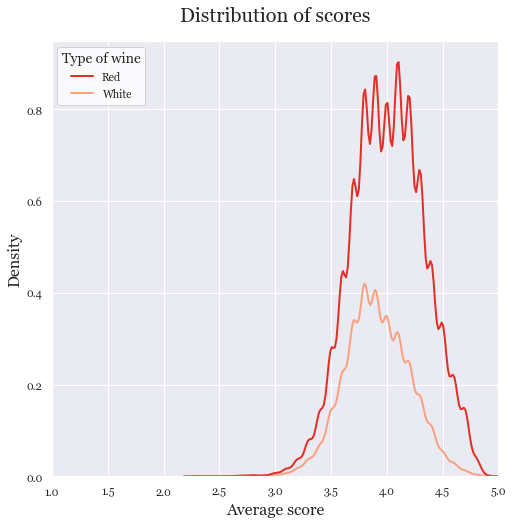

In [148]:
plt.figure(figsize=(8, 8))
ax = sns.kdeplot(data=df[(df['type_name'] == 'White')|(df['type_name'] == 'Red')], 
            x='ratings_average', hue='type_name', palette = 'Reds_r', 
            linewidth=2, legend=True)
modify_legend(ax, 'Type of wine')
plt.xlim(1,5)
# plt.legend(loc='upper left', title='Type of wine', labels=['White', 'Red'], facecolor='white')
plt.xlabel('Average score')
plt.ylabel('Density')
plt.title('Distribution of scores', pad=20)
plt.show()

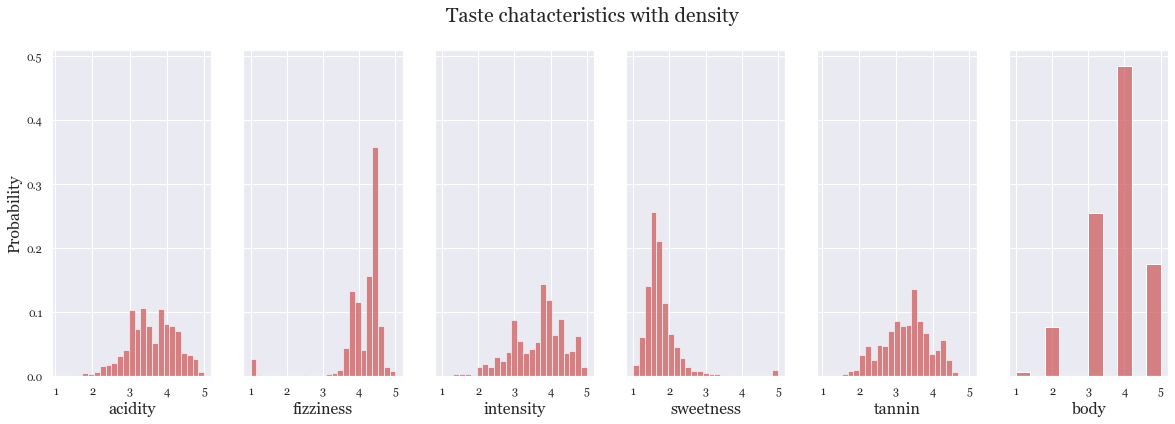

In [149]:
fig, axes = plt.subplots(1, 6, figsize=(20, 6), sharey=True)
plt.suptitle('Taste chatacteristics with density', size=20)
sns.histplot(ax=axes[0], data=df['acidity'], color='indianred', bins=25, stat='probability')
sns.histplot(ax=axes[1], data=df['fizziness'], color='indianred', bins=25, stat='probability')
sns.histplot(ax=axes[2], data=df['intensity'], color='indianred', bins=25, stat='probability')
sns.histplot(ax=axes[3], data=df['sweetness'], color='indianred', bins=25, stat='probability')
sns.histplot(ax=axes[4], data=df['tannin'], color='indianred', bins=25, stat='probability')
sns.histplot(ax=axes[5], data=df['body'], color='indianred', bins=10, stat='probability', )
for ax in axes:
    ax.set_xticks(np.arange(1,6))
plt.show()

In [150]:
df['vintage_type'].value_counts()

0    55074
1      726
2       19
Name: vintage_type, dtype: int64

In order to better understand the nature of the variable 'vintage types' we review separately each of them, and analyze composition of years. 
* **Vintage type 0**: all vintages that have an indication of year (from 1818 to 2020)
* **Vintage type 1**: most of the vintages marked as N.V. (and some individual items marked as non N.V. - to be investigated further)
* **Vintage type 2**: only a few items, some of them matked N.V., others matked with a year. To be investigated further. 

In [151]:
df[df['vintage_type'] == 0]['year'].value_counts().sort_index()

1818       1
1900       1
1910       1
1912       1
1920       1
        ... 
2016    7575
2017    7768
2018    7572
2019    3058
2020      34
Name: year, Length: 91, dtype: int64

In [152]:
df[df['vintage_type'] == 1]['year'].value_counts().head()

0       665
2012      6
2004      5
2009      5
2008      5
Name: year, dtype: int64

In [153]:
df[df['vintage_type'] == 2]['year'].value_counts().head()

0       8
2015    1
2014    1
2013    1
2012    1
Name: year, dtype: int64

In order to investigate why some of the wines have vintage type = 1 and at the same time year 'non-N.V.', we can check individual web pages to find the clues. 

The web-page of each vintage has the format: `https://www.vivino.com/GB/en/[wine_name]/w/[wine_id]?year=[year]`

From a quick review of several examples, we can see that for these types of wines most have no indication of a year on the bottle label, so we assume that year might have been attributed incorrectly. In the future analysis we might want to exclude such inconsistent records.

In [154]:
df[(df['vintage_type'] == 1) & (df['year'] != 0)][['wine_name', 'wine_id', 'year', 'vintage_type']].head()

,wine_name,wine_id,year,vintage_type
62,blanc-de-blancs-brut-champagne-grand-cru-le-me...,9240,1999,1
1026,blanc-de-blancs-brut-champagne-grand-cru-le-me...,9240,2008,1
1076,brut-carte-jaune-champagne,1128385,2008,1
1172,brut-champagne,8302,2008,1
1829,mv,1167182,2000,1


We have also made a manual check of several wines of type 2 that appear to have both N.V. and yearly vintages. Since both types usually are present, we can assume that type 2 refers to the mixed type of vintage (meaning, wine can either be made from the harvest of specific year, or from several years). No action needed.

In [155]:
df[df['vintage_type'] == 2][['wine_name', 'wine_id', 'year', 'vintage_type']].head()

,wine_name,wine_id,year,vintage_type
1269,rose-brut-champagne,1142212,2008,2
4722,edizione-cinque-autoctoni,21646,0,2
4723,malamado-malbec,19488,0,2
4801,rose-brut-champagne,1142212,0,2
6853,rose-brut-champagne,1142212,2009,2


In [156]:
country_freq = df['country'].value_counts(normalize=True)
country_freq.head(11)

France           0.412942
Italy            0.173202
Spain            0.092374
Portugal         0.069711
South Africa     0.047335
United States    0.045398
Australia        0.044753
Argentina        0.021157
New Zealand      0.020601
Chile            0.019974
Germany          0.016406
Name: country, dtype: float64

In [157]:
# remove countries with frequency less than 1% 
country_freq['Other'] = 0
for country in country_freq.keys(): 
    if country_freq[country] < 0.01:
        country_freq['Other'] += country_freq[country]
        country_freq = country_freq.drop(labels = country)

In [158]:
df['country_shortlist'] = df['country'].apply(lambda x: x if x in country_freq.keys() else 'Other')

In [159]:
df['country_shortlist'].value_counts()

France           23031
Italy             9660
Spain             5152
Portugal          3888
South Africa      2640
United States     2532
Australia         2496
Other             2062
Argentina         1180
New Zealand       1149
Chile             1114
Germany            915
Name: country_shortlist, dtype: int64

We can see that 11 countries cover the production of more than 95% of wines that can be imported to GB at a given price. Each of this countries accounts for at least 1% of the wine market. 

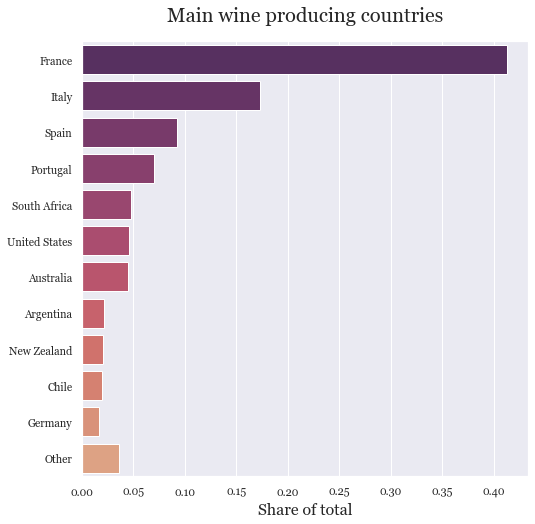

In [160]:
plt.figure(figsize=(8, 8))
sns.barplot(orient='h', x=country_freq.values, y=country_freq.index, palette='flare_r')
plt.xlabel('Share of total')
plt.title('Main wine producing countries', pad=20)
plt.show()

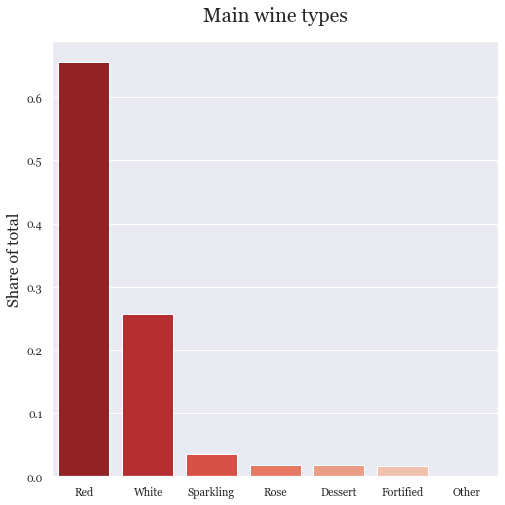

In [161]:
type_freq = df['type_name'].value_counts(normalize=True)
plt.figure(figsize=(8, 8))
sns.barplot(y=type_freq.values, x=type_freq.index, palette='Reds_r')
plt.ylabel('Share of total')
plt.title('Main wine types', pad=20)
plt.show()

## Factors affecting price of wine

In [96]:
# plt.figure(figsize=(8, 8))
# plt.title('Correlation heatmap of existing variables', pad=20)
# sns.heatmap(df.corr())
# plt.show()

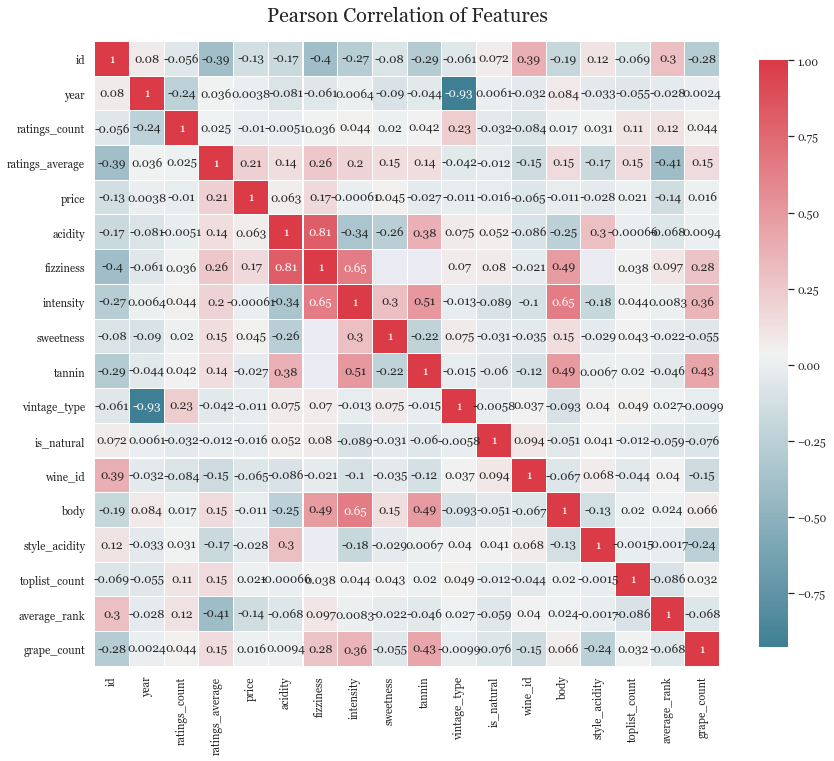

In [98]:
#correlation heatmap of dataset
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', pad=20)   #, y=1.05, size=15

correlation_heatmap(df)

In [30]:
corr_matrix = df.corr()
corr_matrix['price'].sort_values(ascending=False)

price              1.000000
ratings_average    0.201836
fizziness          0.168247
acidity            0.059737
sweetness          0.040037
toplist_count      0.017413
grape_count        0.013465
year               0.003109
intensity         -0.001986
vintage_type      -0.010409
ratings_count     -0.010693
body              -0.011726
is_natural        -0.015677
style_acidity     -0.024442
tannin            -0.027663
wine_id           -0.062120
id                -0.121749
average_rank      -0.140513
Name: price, dtype: float64

None of the existing numerical variables demonstrates high carrelation with the price (the two most promising features are `average_rank` and `ratings_average`.

In order to normalize the prices we need to make sure that we compare only wines of the same volume (therefore, exclude 1/2 bottles and 'magma' bottles from our analysis.

In [31]:
df = df[df.bottle_type=='Bottle (0.75l)']

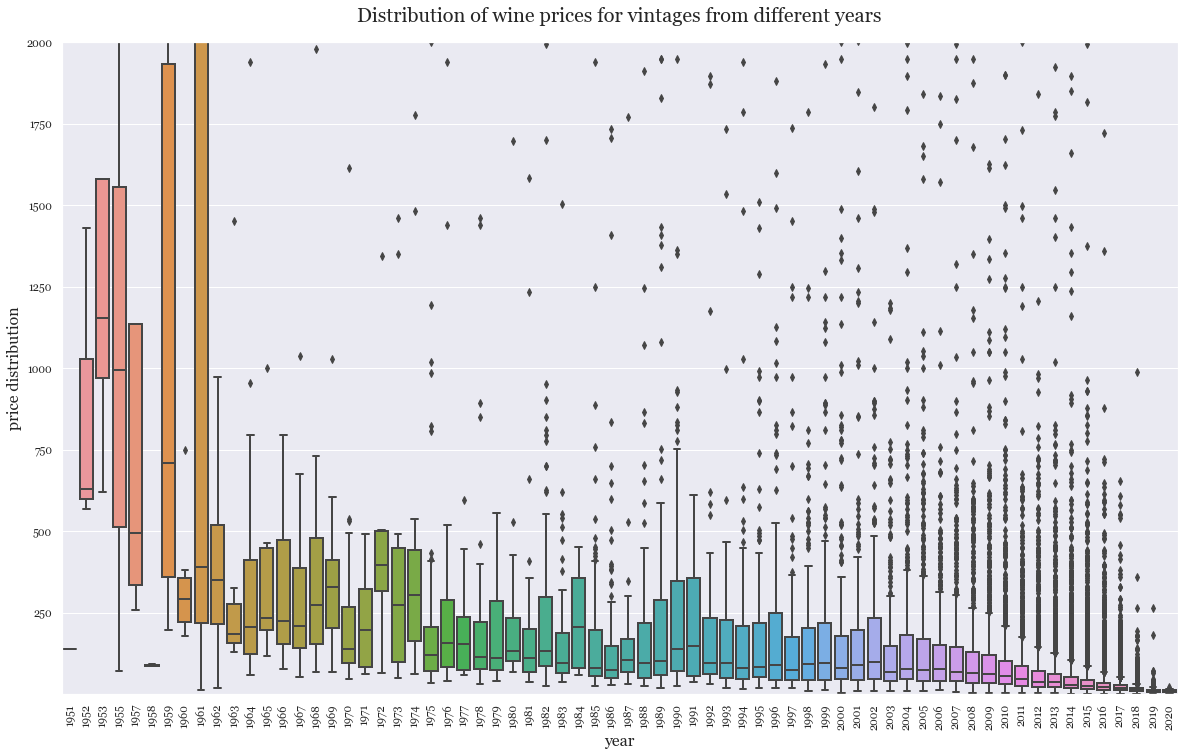

In [32]:
plt.figure(figsize=(20, 12))
sns.boxplot(data=df[df['year']>1950], y='price', x='year', linewidth=2)
plt.ylim((1, 2000))
plt.xticks(rotation=90)
plt.title('Distribution of wine prices for vintages from different years', pad=20)
plt.ylabel('price distribution')
plt.show()
# plt.xlim((1950, 2020))

From the above boxplots we can see that though price is quite predictable in the wines from recent years, the variability of price (and its mean) grow for older vintages. That confirms our expectation that vintage year has certain impact on the wine price. Also, we can notice some abnormal years where the price is beyond the usual pattern (eg. 1972) that might be an indication of some external factors or events (climate, political situation, etc).

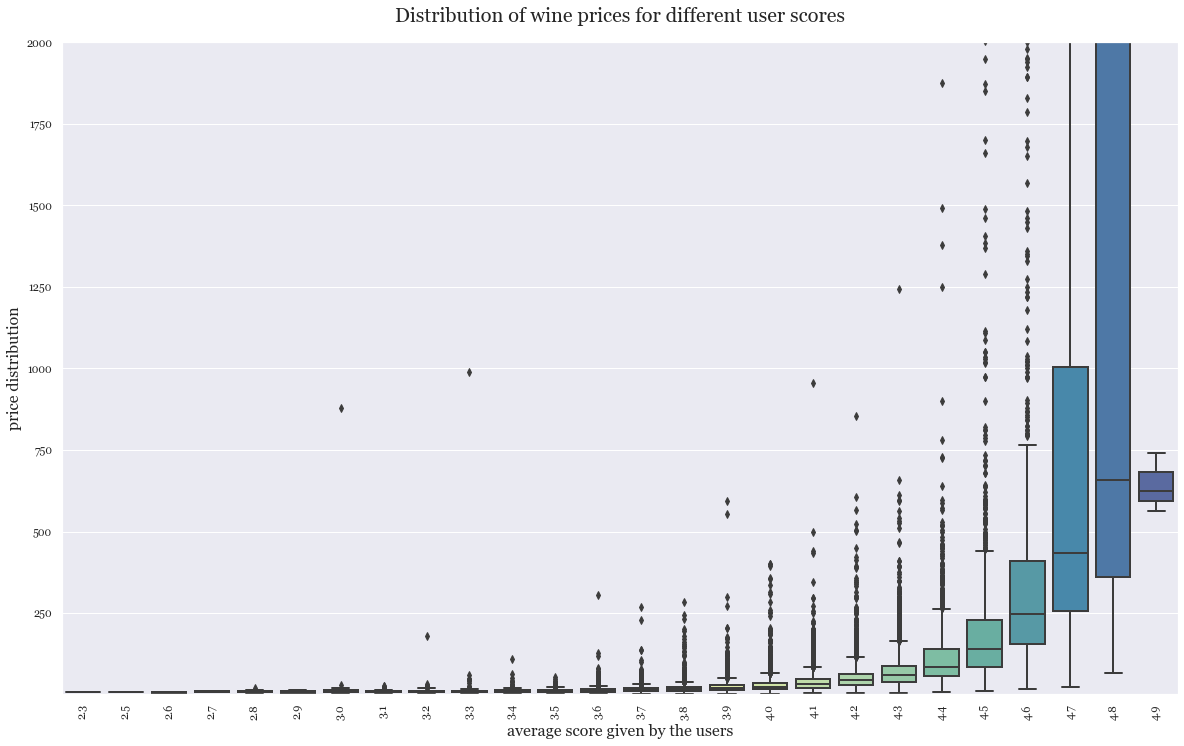

In [33]:
plt.figure(figsize=(20, 12))
sns.boxplot(data=df[df['ratings_count']>50], y='price', x='ratings_average', linewidth=2, palette='Spectral')
plt.ylim((1, 2000))
plt.xticks(rotation=90)
plt.title('Distribution of wine prices for different user scores', pad=20)
plt.ylabel('price distribution')
plt.xlabel('average score given by the users')
plt.show()

In order to make sure that no extreme average scores are given to any specific wine, we chose only those that have at least 50 user ratings.

From the above plot it's clear that price variability grows with the higher user score. The shape of the graph is almost exponential (for the score increase from 4.0 to 4.8 the customers are ready to pay almost 5 times more).

Still, some extreme records exist (e.g. wine 'joven-monastrell-syrah' costs almost 1000 GBP though it has a rating of 3.0).

It would be also interesting to create price bins of similar density and see the score variability within those bins. 

In [34]:
price_percentiles = df.price.quantile(np.arange(0, 1.1, 0.1))
df['price_group'] = pd.cut(df['price'], bins=price_percentiles, include_lowest=True)
df['price_group'].value_counts().sort_index()

(1.699, 9.99]       5388
(9.99, 13.332]      5376
(13.332, 16.6]      5396
(16.6, 20.5]        5408
(20.5, 25.89]       5337
(25.89, 33.5]       5389
(33.5, 45.0]        5470
(45.0, 65.49]       5299
(65.49, 125.0]      5386
(125.0, 28900.0]    5359
Name: price_group, dtype: int64

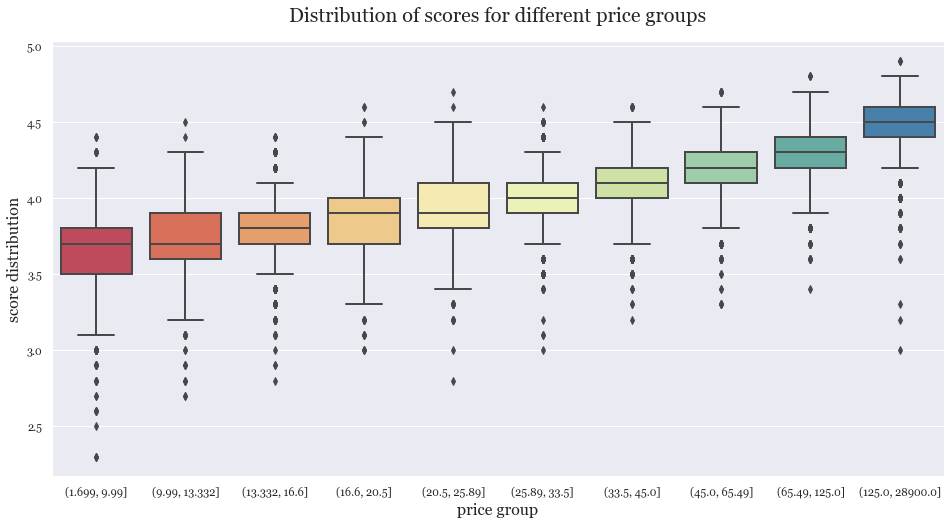

In [35]:
plt.figure(figsize=(16, 8))
sns.boxplot(data=df[df['ratings_count']>50], y='ratings_average', x='price_group', linewidth=2, palette='Spectral')
plt.title('Distribution of scores for different price groups', pad=20)
plt.ylabel('score distribution')
plt.xlabel('price group')
plt.show()

In [36]:
df[(df['ratings_average']<3.1) & ((df['price']>700))][['wine_name', 'wine_id']]

,wine_name,wine_id
26479,joven-monastrell-syrah,1850
32697,joven-monastrell-syrah,1850


In [38]:
df['is_natural'].value_counts()

0    51448
1     2360
Name: is_natural, dtype: int64

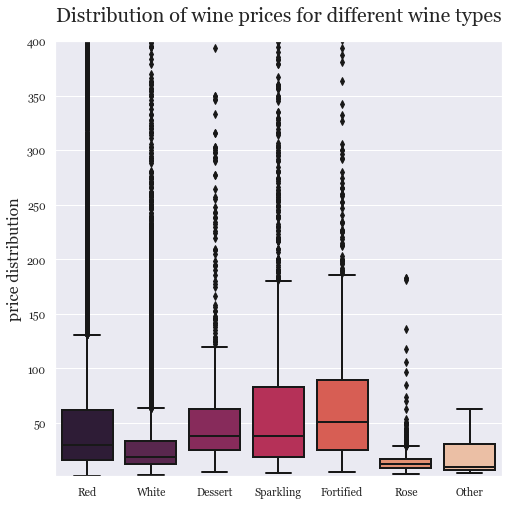

In [39]:
plt.figure(figsize=(8, 8))
# plt.xlim((0, 200))
sns.boxplot(data=df, x='type_name', y='price', linewidth=2, palette='rocket')
plt.ylim((1, 400))
plt.title('Distribution of wine prices for different wine types', pad=20)
plt.ylabel('price distribution')
plt.xlabel('')
plt.show()

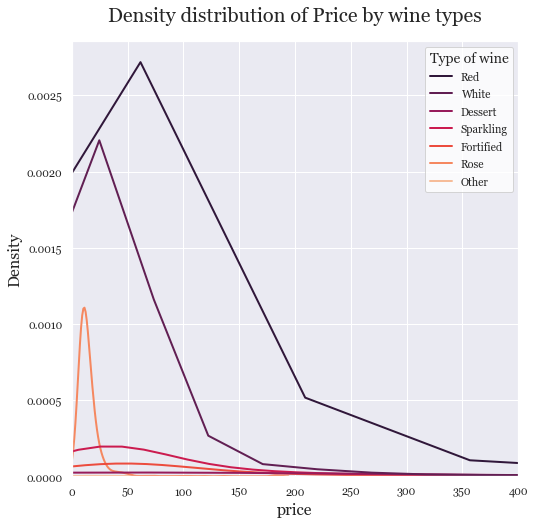

In [40]:
plt.figure(figsize=(8, 8))
plt.xlim((0, 400))
plt.title('Density distribution of Price by wine types', pad=20)
ax = sns.kdeplot(x=df['price'], hue=df['type_name'], linewidth=2, palette='rocket', legend='True') #, hue=['vintage_type']
modify_legend(ax, 'Type of wine', new_loc='upper right')
plt.show()

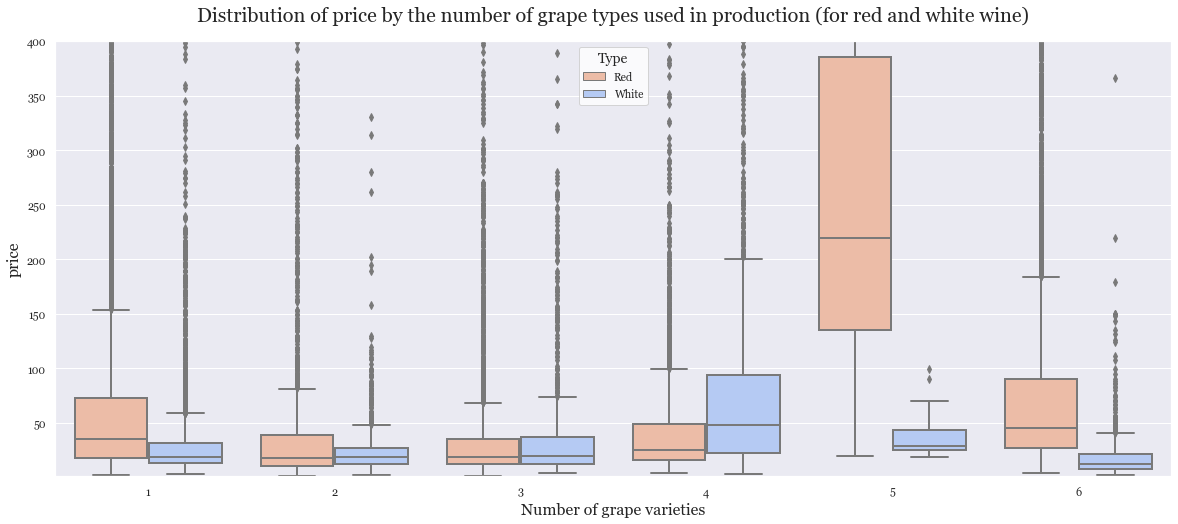

In [173]:
plt.figure(figsize=(20, 8))
# plt.xlim((0, 200))
sns.boxplot(data=df[(df['grape_count']>0) & ((df['type_name'] == 'Red')|(df['type_name'] == 'White'))], x='grape_count', y='price', linewidth=2, hue='type_name', palette='coolwarm_r')
plt.title('Distribution of price by the number of grape types used in production (for red and white wine)', pad=20)
plt.xlabel('Number of grape varieties')
plt.legend(title='Type', facecolor='white')
plt.ylim((1, 400))
plt.show()

From the above plot it seems that wines comprised of 5 grape varieties have certain noticeable differences from those made of 4 or 6 types of grapes. We should analyze it in more detail, since it may tell us more about the wine pricing. 

## Analysis of grape varieties in more detail

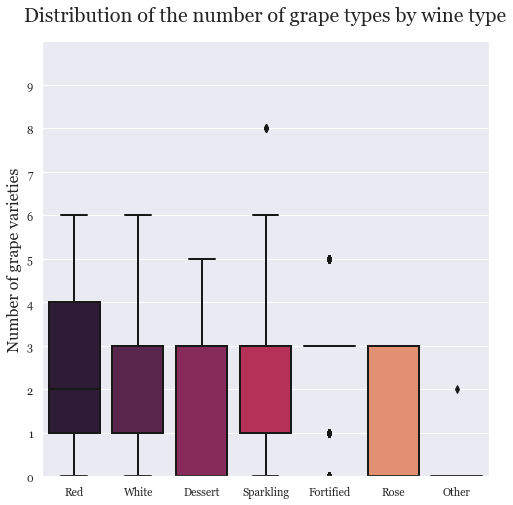

In [42]:
plt.figure(figsize=(8, 8))
# plt.xlim((0, 200))
sns.boxplot(x=df['type_name'], y=df['grape_count'], linewidth=2, palette='rocket')
plt.title('Distribution of the number of grape types by wine type', pad=20)
plt.xlabel('')
plt.ylabel('Number of grape varieties')
plt.yticks(np.arange(0,10))
plt.ylim((0, 10))
plt.show()

It may be the case that certain types of grapes are used in specific combination with other grapes and thus the whole combination affecting the price. In other words, the same type of grapes by itself can be a valueble factor defining price. 

In [162]:
df.grapes.isnull().sum()

6053

When it comes to analysis of combinations, we should analyze red and white wines separately, since difference technologies are used in production of both. 

In [174]:
df_red_with_grapes = df[(df['type_name']=='Red')&(df.grapes.notnull())]
popular_combinations_red = df_red_with_grapes.grapes.value_counts()
# popular_combinations_red[:25]

In [175]:
popular_combinations_red[:25].sum()/len(df_red_with_grapes)

0.9121262799636183

We can see that 25 most popular red grapes combinations account for more than 90% of all red wines. 

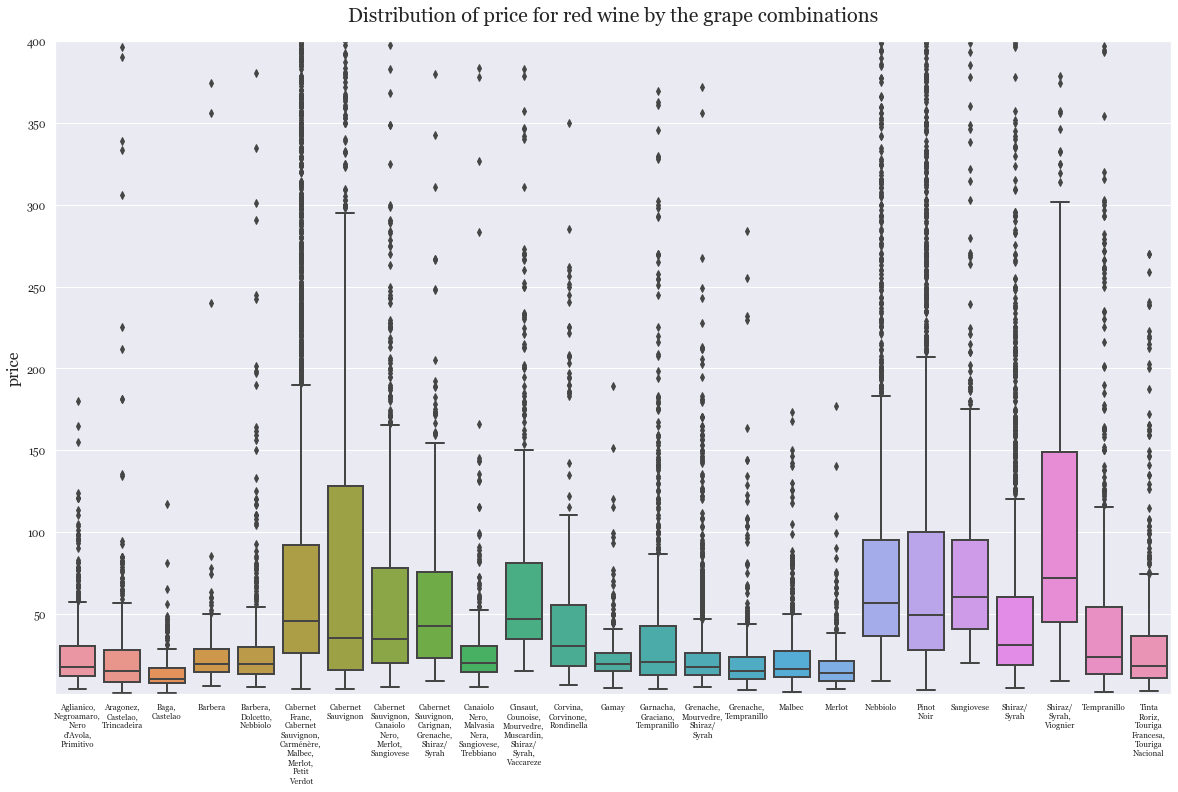

In [176]:
plt.figure(figsize=(20, 12))
# plt.xlim((0, 200))
sns.boxplot(data=df_red_with_grapes[df_red_with_grapes['grapes'].apply(lambda x: x in popular_combinations_red[:25].index)], 
            x='grapes', y='price', linewidth=2, order=popular_combinations_red[:25].sort_index().index)
plt.title('Distribution of price for red wine by the grape combinations', pad=20)
plt.xlabel('')
plt.xticks(np.arange(0,25,1), labels=sorted([label.replace(' ', '\n').replace('/', '/\n') for label in popular_combinations_red[:25].index]), 
           fontsize=8)
plt.ylim((1, 400))
# print(plt.xticks)
plt.show()

In [177]:
df_white_with_grapes = df[(df['type_name']=='White')&(df.grapes.notnull())]
popular_combinations_white = df_white_with_grapes.grapes.value_counts()
# popular_combinations_white[:20]

In [178]:
popular_combinations_white[:20].sum()/len(df_white_with_grapes)

0.9054996755353667

20 most popular white grapes combinations account for more than 90% of white wine

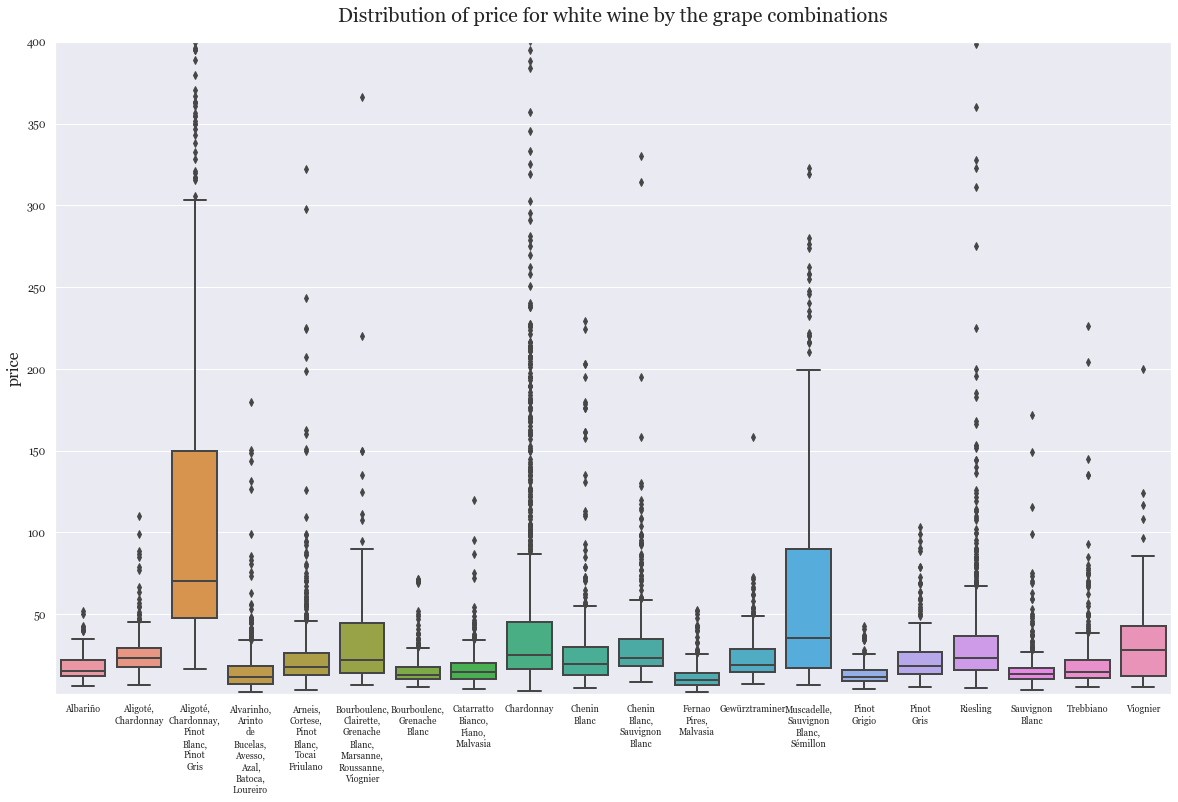

In [179]:
plt.figure(figsize=(20, 12))
# plt.xlim((0, 200))
sns.boxplot(data=df_white_with_grapes[df_white_with_grapes['grapes'].apply(lambda x: x in popular_combinations_white[:20].index)], 
            x='grapes', y='price', linewidth=2, order=popular_combinations_white[:20].sort_index().index)
plt.title('Distribution of price for white wine by the grape combinations', pad=20)
plt.xlabel('')
plt.xticks(np.arange(0,20,1), labels=sorted([label.replace(' ', '\n').replace('/', '/\n') for label in popular_combinations_white[:20].index]), 
           fontsize=9)
plt.ylim((1, 400))
# print(plt.xticks)
plt.show()

In [180]:
df[(df['grape_count'] == 5)&(df['type_name']=='Red')]['style_name'].value_counts()

Napa Valley Bordeaux Blend    211
Name: style_name, dtype: int64

All 5-grape red wines correspond to the special US blend (Napa Valley Bordeaux Blend) that can explain the high price. The grapes are: 
* Malbec
* Cabernet Sauvignon
* Petit Verdot
* Cabernet Franc
* Merlot

In [181]:
df[(df['grape_count'] == 6)&(df['type_name']=='Red')]['grapes'].value_counts()

Cabernet Franc, Cabernet Sauvignon, Carménère, Malbec, Merlot, Petit Verdot    7310
Cinsaut, Counoise, Mourvedre, Muscardin, Shiraz/Syrah, Vaccareze                711
Name: grapes, dtype: int64

Most of 6-grape red wine blends relate to various French Bordeaux blend styles. The grapes are: 
* Malbec
* Merlot
* Cabernet Sauvignon
* Petit Verdot
* Carménère
* Cabernet Franc

In [184]:
df[df['grape_count'] == 6]['country'].value_counts()

France           7618
Portugal          677
South Africa      232
Chile              83
Australia          79
Argentina          74
United States      73
New Zealand        57
Brazil              2
Name: country, dtype: int64

In [185]:
french_bardeux_styles = df[(df['country'] == 'France') & 
          (df['grapes'] == 'Cabernet Franc, Cabernet Sauvignon, Carménère, Malbec, Merlot, Petit Verdot')]['style_name'].unique()

french_bardeux_styles

# .groupby('style_name')[['price', 'ratings_average', 'acidity', 'intensity', 'sweetness', 'tannin', 'body']].agg({
#     'price': ['median', 'mean', 'sem']}).sort_values(by='price', ascending=False)

array(['Bordeaux Margaux', 'Bordeaux Pauillac', 'Bordeaux Saint-Émilion',
       'Bordeaux Pessac-Léognan', 'Bordeaux Médoc', 'Bordeaux Red',
       'Bordeaux Saint-Julien', 'Bordeaux Saint-Estèphe',
       'Bordeaux Pomerol', 'Bordeaux Libournais Red',
       'Bordeaux Graves Red'], dtype=object)

In [186]:
french_bardeux_styles_df = df[df['style_name'].apply(lambda x: x in french_bardeux_styles)]

In [187]:
french_bardeux_styles_df.pivot_table(values=['price', 'ratings_average'], 
                                     index='style_name', 
                                     aggfunc=['median', 'mean', 'std']).sort_values(by=('median','price'), ascending=False)

median                        mean                  \
                            price ratings_average       price ratings_average   
style_name                                                                      
Bordeaux Pauillac        89.97500             4.3  240.485616        4.245619   
Bordeaux Pomerol         68.16665             4.2  301.193434        4.193519   
Bordeaux Saint-Julien    66.39000             4.2   96.668965        4.148893   
Bordeaux Pessac-Léognan  55.66665             4.1  121.458970        4.143625   
Bordeaux Margaux         52.32000             4.1  114.234220        4.133869   
Bordeaux Saint-Émilion   51.85000             4.1  110.025381        4.126024   
Bordeaux Saint-Estèphe   41.42835             4.0   63.611309        4.021564   
Bordeaux Médoc           23.91000             3.8   28.839405        3.807917   
Bordeaux Libournais Red  21.50000             3.8   28.370858        3.822222   
Bordeaux Graves Red      15.95000             3.8   19.956396        3.723636   
Bordeaux Red             14.33330             3.7   76.173170        3.709980   

                                 std                  
                               price ratings_average  
style_name                                            
Bordeaux Pauillac         572.276968        0.267907  
Bordeaux Pomerol         1012.080352        0.265043  
Bordeaux Saint-Julien     180.988558        0.203547  
Bordeaux Pessac-Léognan   198.356174        0.262320  
Bordeaux Margaux          401.753346        0.236862  
Bordeaux Saint-Émilion    222.405399        0.269289  
Bordeaux Saint-Estèphe     65.441053        0.220633  
Bordeaux Médoc             16.700676        0.212759  
Bordeaux Libournais Red    29.253536        0.201806  
Bordeaux Graves Red        11.654341        0.209022  
Bordeaux Red              699.212128        0.292425

## Price prediction

We might see the accuracy of price predicted based on the given criteria and see whether wine score adds accuracy to the prediction.

In [127]:
#preprocessing and transformation libraries
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedShuffleSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn import feature_selection

#Common Model Algorithms
from sklearn import svm, tree, linear_model
from xgboost import XGBRegressor

In [188]:
df.columns

Index(['id', 'year', 'ratings_count', 'ratings_average', 'price', 'acidity',
       'fizziness', 'intensity', 'sweetness', 'tannin', 'vintage_type',
       'is_natural', 'wine_name', 'wine_id', 'region', 'country', 'style_name',
       'body', 'style_acidity', 'type_name', 'winery_name', 'bottle_type',
       'grapes', 'toplist_count', 'average_rank', 'grape_count'],
      dtype='object')

First, we divide out dataset into training and test set. 

In [189]:
train_set, test_set = train_test_split(df, test_size=0.2)

In [190]:
data_cleaner = [train_set, test_set]

In [192]:
df.isnull().sum()

id                     0
year                   0
ratings_count          0
ratings_average        0
price                  0
acidity             7617
fizziness          54311
intensity           7617
sweetness           9125
tannin             22265
vintage_type           0
is_natural             0
wine_name              0
wine_id                0
region                46
country               46
style_name          6053
body                6053
style_acidity       6053
type_name              0
winery_name           16
bottle_type            0
grapes              6053
toplist_count          0
average_rank       54362
grape_count            0
dtype: int64

We might want to eliminate rows with no data about `region`, `country` or `winery`.

The following columns need to be filled with some values according to the mode value of vintages from similar style: 
* acidity 
* fizziness 
* intensity 
* sweetness 
* tannin 
* style_name
* body
* style_acidity
* grapes

`average_rank` can be 40 for wines that were not present in any lists